## Notebook for Figure 4

In [ ]:
%matplotlib inline

import tqdm
import os 

import xarray as xr
import numpy as np 

# importing the TDigest package
from crick import TDigest

#Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.patches as patches
import cartopy.crs as ccrs

os.chdir("/home/b/b382291/git/one_pass_algorithms_paper/")
from algorithms.algorithms import init_tdigests
from algorithms.algorithms import update_tdigests


Load data and extract wind speed. 

The wind speed has been calculated using the square root of the sum of the two horizontal wind components from the IFS model, run as part of the nextGEMS cycle 3 runs.

Showing hourly data over December 2020.

We have re-sampled the data down to r100 for usabiltiy: this allows us to demonstrate the streaming algorithms by loading all the data in memory and then looping through.

In operational mode this would done via an automated workflow manager or similar that would pass higher resolution data to the algorithms chunk by chunk.

In [3]:
ds = xr.open_dataset("/work/bb1153/b382291/opa_paper_data/wind_speed_dec_2020_IFS_tco2559_ng5_cycle3_r100.nc")
ds

<xarray.Dataset> Size: 386MB
Dimensions:                 (time: 744, lat: 180, lon: 360)
Coordinates:
  * time                    (time) datetime64[ns] 6kB 2020-12-01 ... 2020-12-...
  * lat                     (lat) float64 1kB -89.95 -88.95 ... 88.05 89.05
  * lon                     (lon) float64 3kB 0.0 1.0 2.0 ... 357.0 358.0 359.0
Data variables:
    wind_speed_rms_u10_v10  (time, lat, lon) float64 386MB ...
Attributes: (12/16)
    paramId:                    166
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    cfVarName:                  v10
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    regridded:                  1

Here we run the functions 'init_digests' and 'update_digests' that creates digests for the streamed data and adds the new data chunks to the digests. We use a weight of 4 for each data chunk.

In [4]:
# extract data array
ws = ds.wind_speed_rms_u10_v10

step = 4
n = 0

# inside the package this calculated based on the time stamp of the incoming data and the
# time step of the data, however here just setting it for convienece
c = len(ws.time)

# simulating the streamed data
for hour in tqdm.tqdm(range(0, c, step)):

    data_chunk = ws.isel(time = slice(hour, hour+step))
    w = len(data_chunk.time)

    if hour == 0:
        digest_list, size_data_source_tail = init_tdigests(data_chunk)

    n, digest_list = update_tdigests(data_chunk.values, size_data_source_tail,
        digest_list, n,  w)

100%|██████████| 186/186 [00:38<00:00,  4.83it/s]


We now want to calculate the estimated value of each percentile from using the t-digest comapred to the estimate from using NumPy. 

Here we calculate the NumPy estimate for every percentile value over the spatial grid (we flatten the array to match the shape of the digest list)

In [ ]:
# list of quantiles we want to loop thorugh
quantiles = np.linspace(0, 100, 101)
# empty array that will story all the NumPy percentile estimates for every grid cell
percen_np = np.zeros([len(quantiles), size_data_source_tail])
# flattening the array over the spatial grid
ws_flat = np.reshape(ws.values, [len(ws.time), size_data_source_tail])
# going through every quantile 
for index, quantile in tqdm.tqdm(enumerate(quantiles)):
    percen_np[index, :] = np.percentile(ws_flat, axis = 0, q = quantile, method = 'linear')


101it [01:14,  1.35it/s]


Here we calculate the t-dgiest estimate for every percentile value over the spatial grid

In [6]:
# empty array that will story all the tdigest estimates for every grid cell
percen_digest = np.zeros([len(quantiles), size_data_source_tail])

# looping through all the grid cells 
for g in tqdm.tqdm(range(size_data_source_tail)):
    # going through every quantile 
    for index, quantile in enumerate(quantiles):
        percen_digest[index,g] = digest_list[g].quantile(quantile/100)
        

100%|██████████| 64800/64800 [00:29<00:00, 2203.18it/s]


We now compare the NumPy estimate against the t-dgiest estimate and provide the error as a percentage of the NumPy value

In [7]:
time_dim, lat_size, lon_size = np.shape(data_chunk)

per_error = ((percen_digest - percen_np)/percen_np) * 100        

# averaging the error across all the percentiles
average_error = np.mean(abs(per_error), axis = 0)

# reshape array back to lat lon
total_per_error = np.reshape(average_error, [1, lat_size, lon_size])

Loading the two time series for the Moray East wind farm in the North Sea and the Rosoe wind farm in Texas, North America. These time series were extracted from the native resolution data to be more accurate with the location. If you want to change the location of these points to examine different locations, uncomment the code below (uk_time_series or texas_time_series) |to select dat from the downsampled dataset

In [8]:
# uk monthly data
uk_time_series = xr.load_dataarray("/work/bb1153/b382291/opa_paper_data/wind_speed_dec_uk_IFS_tco2559_ng5_cycle3_r010.nc")
# texas monthly data
texas_time_series = xr.load_dataarray("/work/bb1153/b382291/opa_paper_data/wind_speed_dec_texas_IFS_tco2559_ng5_cycle3_r010.nc")

In [9]:
# defining a function to give the closest lat lon indicies based on a target lat lon
def closest_value(input_list, input_value):
  arr = np.asarray(input_list)
  i = (np.abs(arr - input_value)).argmin()
  return arr[i]

Here we match the co-ordinates of the two wind farm locations to their closest location on the overall wind speed dataset to allow for plotting. 

To use data from the downsampled data set, uncomment the uk_time_series line

In [10]:
# target lat and lon for the Moray East wind farm
target_lat = 58.25
target_lon = 2.75

target_lon_new = closest_value(ds.lon.values, target_lon)
target_lat_new = closest_value(ds.lat.values, target_lat)

# getting the target index to draw the locations on the global map
target_index_uk_lat = np.where(ds.lat.values == target_lat_new)[0][0]
target_index_uk_lon = np.where(ds.lon.values == target_lon_new)[0][0]

# uk_time_series = ds.wind_speed_rms_u10_v10[:, target_index_uk_lat, target_index_uk_lon]


In [11]:
# target lat and lon for the Roscoe wind farm
target_lat = 32.35
target_lon = 360-100.55

target_lon_new = closest_value(ds.lon.values, target_lon)
target_lat_new = closest_value(ds.lat.values, target_lat)

target_index_texas_lat = np.where(ds.lat.values == target_lat_new)[0][0]
target_index_texas_lon = np.where(ds.lon.values == target_lon_new)[0][0]

# texas_time_series = ds.wind_speed_rms_u10_v10[:, target_index_texas_lat, target_index_texas_lon]

Here, we are using these two specific locations to evaluate the effect of the compression parameter on the t-digest estimate. As the 'init_digests' and 'update_digests' functions use a compression factor of 60, here we are intialsing and updating the digests explicitly.

In [12]:
compression_spacing = 2

# min and max compression factors to span across
max_comp = 140
min_comp = 20
spacing = int((max_comp - min_comp)/compression_spacing)+1
compressions = np.linspace(min_comp, max_comp, spacing)
num_compressions = len(compressions)

digest_list_uk = []
digest_list_texas = []

for i in range(num_compressions): 
    digest_list_uk.append(TDigest(compression = compressions[i]))
    digest_list_texas.append(TDigest(compression = compressions[i]))

    # simulating streaming by adding data to the digests incrementally
    for j in range(len(uk_time_series)):
        digest_list_uk[i].update(uk_time_series[j])
        digest_list_texas[i].update(texas_time_series[j])

Here we are calcluating the difference between the NumPy and t-digest estimates for these two specfic locations based on the full range of compression factors. We then conduct a detailed analysis for the 50th and 80th percentile, comparing with the range of estimates obtained from using different NumPy interpolation schemes.

In [13]:
# specific quantiles to examine
quantiles = [50, 80]

digest_percen_est_uk = np.zeros([num_compressions])
digest_percen_est_texas = np.zeros([num_compressions])
centriod_num_uk = np.zeros([num_compressions, len(quantiles)])
centriod_num_texas = np.zeros([num_compressions, len(quantiles)])

errors = np.zeros([2, num_compressions, len(quantiles)])
errors_p = np.zeros([2, num_compressions, len(quantiles)])
errors_bars = np.zeros([4, num_compressions, len(quantiles)])
errors_bars_p = np.zeros([4, num_compressions, len(quantiles)])
error_other = np.zeros([8, 2, num_compressions, len(quantiles)])
percen_np = np.zeros([8])
    
for q in range(len(quantiles)):

    for i in range(num_compressions):
        digest_percen_est_uk[i] = digest_list_uk[i].quantile(quantiles[q]/100)
        digest_percen_est_texas[i] = digest_list_texas[i].quantile(quantiles[q]/100)

        centriod_num_uk[i, q] = np.size(digest_list_uk[i].centroids())
        centriod_num_texas[i, q] = np.size(digest_list_texas[i].centroids())

    for h in range(2):
        if h == 0:
            time_series = uk_time_series
            digest_percen_est = digest_percen_est_uk
        elif h == 1:
            time_series = texas_time_series
            digest_percen_est = digest_percen_est_texas

        # calculating the NumPy percentile estimate using the avaliable interpolation schemes
        percen_np[0] = np.percentile(time_series, q = quantiles[q], method = 'inverted_cdf')
        percen_np[1] = np.percentile(time_series, q = quantiles[q], method = 'averaged_inverted_cdf')
        percen_np[2] = np.percentile(time_series, q = quantiles[q], method = 'closest_observation')
        percen_np[3] = np.percentile(time_series, q = quantiles[q], method = 'interpolated_inverted_cdf')
        percen_np[4] = np.percentile(time_series, q = quantiles[q], method = 'hazen')
        percen_np[5] = np.percentile(time_series, q = quantiles[q], method = 'weibull')
        percen_np[6] = np.percentile(time_series, q = quantiles[q], method = 'normal_unbiased')
        percen_np[7] = np.percentile(time_series, q = quantiles[q], method = 'linear')

        errors[h, :, q] = (digest_percen_est - percen_np[7])
        errors_p[h,:, q] = errors[h, :, q]/(percen_np[7]).data * 100 
        
         # looping through compressions
        for kl in range(len(digest_percen_est)):
            # absolute error bars
            errors_bars[2*h+1, kl, q] = np.max(digest_percen_est[kl] - percen_np)  - errors[h,kl,q]  # upper 
            errors_bars[2*h, kl, q] = errors[h,kl,q]- np.min(digest_percen_est[kl] - percen_np)  # lower 
            # percentile error bars
            errors_bars_p[2*h+1, kl, q] = (
                                (np.max((digest_percen_est[kl] - percen_np)/percen_np))  - 
                                errors[h,kl,q]/percen_np[7]
                                ) * 100 # upper error bar
            errors_bars_p[2*h, kl, q] = (
                                errors[h,kl,q]/percen_np[7] - np.min((digest_percen_est[kl] - 
                                percen_np)/percen_np)
                                ) * 100 # lower error bar

Now to plot the Figure

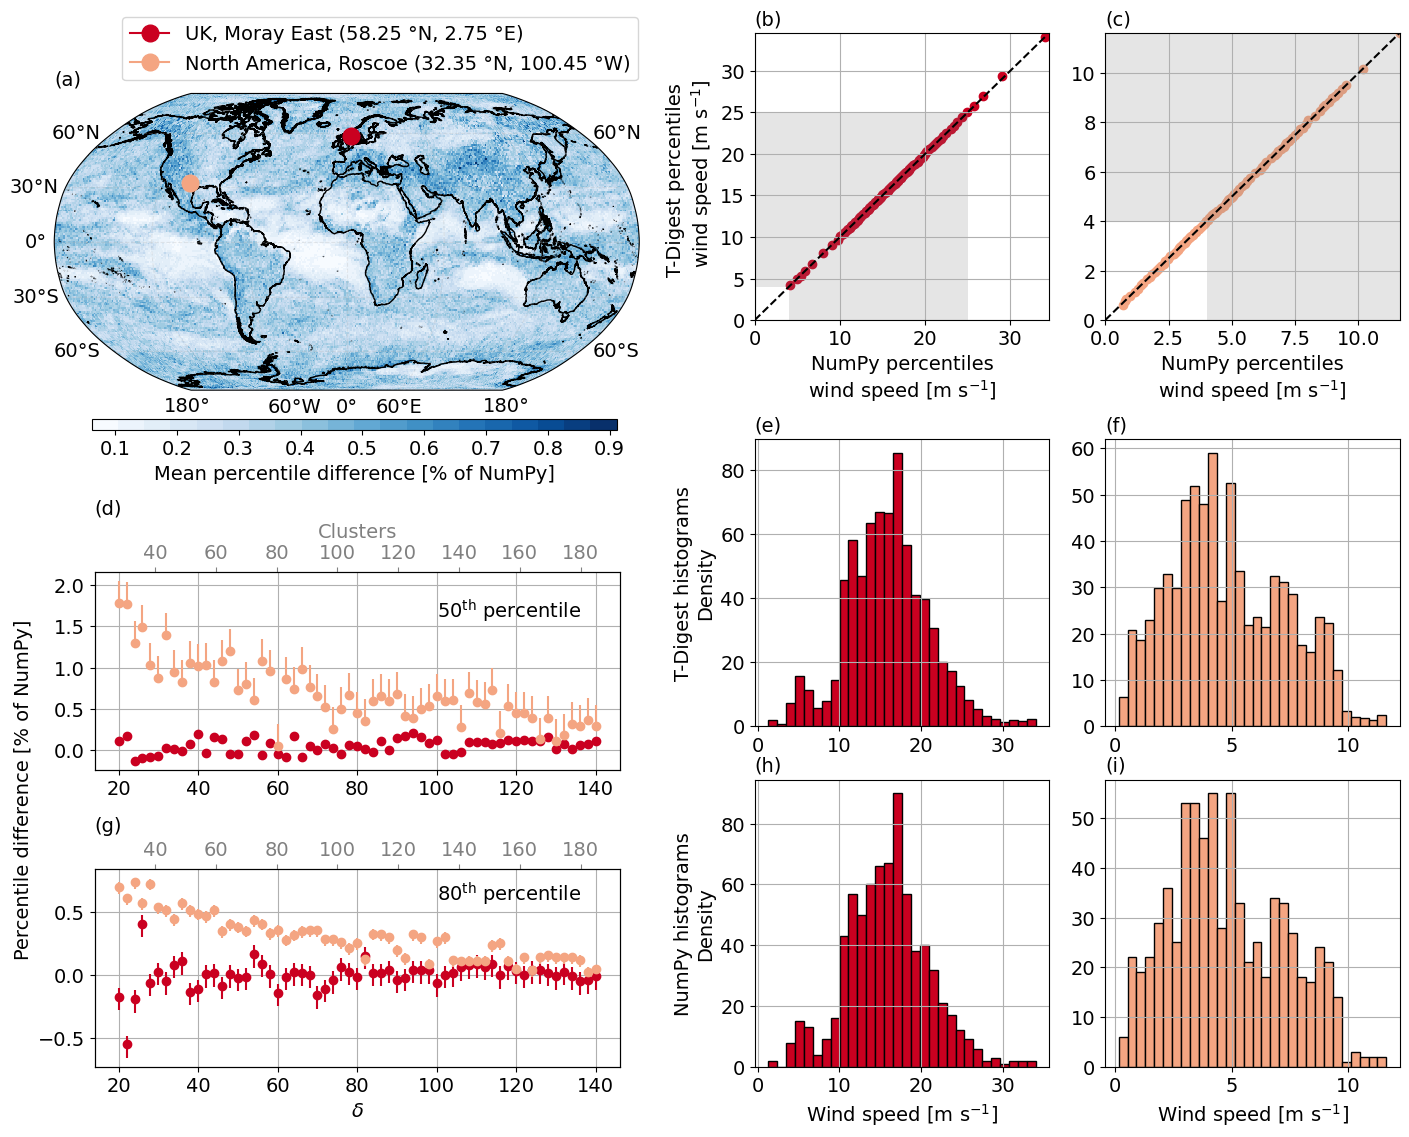

In [18]:
robinson = ccrs.Robinson()
geodetic = ccrs.Geodetic()
fig = plt.figure(constrained_layout=False, figsize=(15,11))
fig.subplots_adjust(bottom=0.1, top=0.97, left=0.01, right=0.86, wspace = 0.5, hspace = 0.2)

nrow = 3
ncol = 3
outer = gs.GridSpec(nrow,ncol,wspace=0.2,hspace=0.3, width_ratios=[0.9, 0.45, 0.45])

# fontsize
fsize = 14

# size of histogram inserts
ss_hist = 0.1
xp = 0.79
x_shift = 0.035
x_shift2 = 0.02

# compression factor for the histograms is 60 *array index is 20)
comp_index = 20

# defining colours for plotting
c1 = '#ca0020' 
c2 = '#f4a582'
c3 = '#92c5de' 
c4 = '#0571b0'

for i in range(nrow*ncol):

    if i == 0:
        # setting the global map
        # [left, bottom, width, height]
        ax = fig.add_axes([0.023, 0.625, 0.39, 0.39], projection = robinson)

        fig.subplots_adjust(bottom=0.05, top=0.99, left=0.01, right=0.9, wspace = 0.2, hspace = 0.4)
        ax.coastlines(resolution = '10m')

        #meridians and parallels
        gl = ax.gridlines(draw_labels = True,linestyle='dashed',alpha=0.25)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': fsize}
        gl.ylabel_style = {'size': fsize}

        cmap = plt.get_cmap('Blues', 20)
        lon2d, lat2d = np.meshgrid(ds.lon, ds.lat)
        cs = ax.pcolormesh(lon2d, lat2d, total_per_error[0,:,:], transform=ccrs.PlateCarree(),cmap=cmap)
        
        lon1 = ds.lon[target_index_uk_lon].values
        lat1 = ds.lat[target_index_uk_lat].values

        lon2 = ds.lon[target_index_texas_lon].values
        lat2 = ds.lat[target_index_texas_lat].values
        
        #Transform the coordinates of the rectangles to the projection coordinates
        rect1 = robinson.transform_point(lon1, lat1, geodetic)
        rect2 = robinson.transform_point(lon2, lat2, geodetic)

        ax.plot(rect1[0], rect1[1], color=c1, marker='o', markersize=12,
                transform=robinson, label = 'UK, Moray East (58.25 °N, 2.75 °E)')
        ax.plot(rect2[0], rect2[1], color=c2, marker='o', markersize=12,
            transform=robinson, label = "North America, Roscoe (32.35 °N, 100.45 °W)")
        ax.set_title('(a)', fontsize = fsize, loc = 'left')

        ax.legend(loc = 'upper left', bbox_to_anchor=(0.1, 1.29), fontsize = fsize)

        pos = ax.get_position()
        new_pos = [pos.x0, pos.y0-0.02, pos.width, pos.height] 
        ax.set_position(new_pos)

        # Add color bar for each subplot
        cbar_ax = fig.add_axes([0.048, 0.629, 0.35, 0.01])
        cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
        #cbar.set_ticks(cbar.get_ticks()[::-1])        
        cbar.set_label('Mean percentile difference [% of NumPy]', rotation=0, fontsize = fsize)
        cbar.ax.tick_params(labelsize=fsize)
        cbar.update_ticks()

    elif i == 1:

        # quantile quantile plot for the UK wind farm
        percen_digest = np.zeros(100)
        percen_np = np.zeros(100)
        quantiles = np.linspace(1, 100, 100)
        alpha = 0.2
        # Create main scatter plot
        
        ax = plt.subplot(outer[i])
        pos = ax.get_position()
        new_pos = [pos.x0 + x_shift, pos.y0, pos.width, pos.height] 
        ax.set_position(new_pos)

        ax.set_ylabel('T-Digest percentiles \n wind speed [m s$^{-1}$]', fontsize = fsize)
        ax.set_xlabel('NumPy percentiles\nwind speed [m s$^{-1}$]', fontsize = fsize)        
        ax.tick_params('y', labelsize = fsize)
        ax.tick_params('x', labelsize = fsize)
        ax.grid(True)
        ax.set_title('(b)', fontsize = fsize, loc = 'left')

        # for each percentile extracting the TDigest and NumPy estimate
        for i in range(100):
            percen_digest[i] = digest_list_uk[comp_index].quantile(quantiles[i]/100)
            percen_np[i] = np.percentile(uk_time_series, q = quantiles[i])

        text_height = 0.9*np.max(percen_digest)
        ax.scatter(percen_np, percen_digest, color=c1)
        # adding the x = y line 
        x_values = np.linspace(0,np.max(uk_time_series.values),100)
        y_values = x_values
        ax.plot(x_values, y_values, label='x = y', linestyle="--", color='black')

        # adding gray patches to show range of wind farm operating speeds
        x_start, x_end = 4, 25
        y_bottom, y_top = 0, 25
        rectangle = patches.Rectangle((x_start, y_bottom), x_end - x_start, y_top - y_bottom,
                                    linewidth=1, edgecolor='None', facecolor='gray', 
                                    alpha=alpha)
        ax.add_patch(rectangle)
        x_start, x_end = 0, 4
        y_bottom, y_top = 4, 25
        rectangle = patches.Rectangle((x_start, y_bottom), x_end - x_start, y_top - y_bottom,
                                    linewidth=1, edgecolor='None', facecolor='gray', 
                                    alpha=alpha)
        ax.add_patch(rectangle)  
        ax.set_xlim([0,np.max(percen_np)+0.5])      
        ax.set_ylim([0,np.max(percen_digest)+0.5])
         
    elif i == 2:   
        
        # quantile quantile plot for the Texas wind farm
        ax = plt.subplot(outer[i])
        pos = ax.get_position()
        new_pos = [pos.x0 + x_shift2, pos.y0, pos.width, pos.height] 
        ax.set_position(new_pos)

        percen_digest = np.zeros(100)
        percen_np = np.zeros(100)

        ax.set_xlabel('NumPy percentiles\nwind speed [m s$^{-1}$]', fontsize = fsize)        
        #ax.set_ylabel(r'T-Digest percentiles - wind speed [m s$^{-1}$]', fontsize = fsize)
        ax.tick_params('y', labelsize = fsize)
        ax.tick_params('x', labelsize = fsize)
        ax.grid(True)
        ax.set_xlim([0, np.max(texas_time_series)])
        ax.set_ylim([0, np.max(texas_time_series)])
        ax.set_title('(c)', fontsize = fsize, loc = 'left')

        # extracting the TDigest and NumPy percentile estimates
        for i in range(100):
            percen_digest[i] = digest_list_texas[comp_index].quantile(quantiles[i]/100)
            percen_np[i] = np.percentile(texas_time_series, q = quantiles[i])

        ax.scatter(percen_np, percen_digest, color=c2)
        text_height = 0.9*np.max(percen_digest)
  
        # adding x = y line
        ax.plot(x_values, y_values, label='x = y', linestyle="--", color='black')

        # adding gray patches to show range of wind farm operating speeds
        x_start, x_end = 4, 25
        y_bottom, y_top = 0, 25
        rectangle = patches.Rectangle((x_start, y_bottom), x_end - x_start, y_top - y_bottom,
                                    linewidth=1, edgecolor='None', facecolor='gray', 
                                    alpha=alpha)
        ax.add_patch(rectangle)

        x_start, x_end = 0, 4
        y_bottom, y_top = 4, 25
        rectangle = patches.Rectangle((x_start, y_bottom), x_end - x_start, y_top - y_bottom,
                                    linewidth=1, edgecolor='None', facecolor='gray', 
                                    alpha=alpha)
        ax.add_patch(rectangle)

    elif i == 3:
        
        # 50th and 80th percentile errors as a function of compression
        # factors to get the correct location
        ss = 0.175
        extra = 0.005
        
        ax = fig.add_axes([0.05, 0.32, ss*2, ss+extra])  # [left, bottom, width, height]
        ax.errorbar(compressions, errors_p[0, :,0], yerr = errors_bars_p[0:2, :,0], marker = 'o', color=c1,linestyle='')
        ax.errorbar(compressions, errors_p[1, :,0], yerr = errors_bars_p[2:4, :,0], marker = 'o', color=c2,linestyle='')
        obh = ax.set_ylabel('Percentile difference [% of NumPy]', fontsize = fsize, labelpad = 15)
        obh.set_position((0, -0.1))  # Adjust the position tuple as needed

        ax.grid(True)
        text_height = 0.9*np.max(errors_p[1, :, 0])
        ax.tick_params('y', labelsize = fsize)
        ax.tick_params('x', labelsize = fsize)
        ax.text(100, text_height, r'50$^{\text{th}}$ percentile', fontsize = fsize)
        ax.set_title('(d)', fontsize = fsize, loc = 'left')
        #Create a second x-axis sharing the same x-axis
        ax2 = ax.twiny()
        ax2.scatter(centriod_num_uk[:,0], errors[0,:,0], color='gray', marker = '')
        ax2.set_xlabel('Clusters', color='gray', fontsize = fsize)
        ax2.tick_params('x', colors='gray', labelsize = fsize)

        text_height = 0.8*np.max(errors_p[1, :, 1])
        ax = fig.add_axes([0.05, 0.05, ss*2, ss+extra])  # [left, bottom, width, height]
        ax.errorbar(compressions, errors_p[0, :, 1], yerr = errors_bars_p[0:2, :,1], marker = 'o', color=c1,linestyle='')
        ax.errorbar(compressions, errors_p[1, :, 1], yerr = errors_bars_p[2:4, :,1]*2, marker = 'o', color=c2,linestyle='')
        ax.tick_params('y', labelsize = fsize)
        ax.tick_params('x', labelsize = fsize)
        ax.text(100, text_height, r'80$^{\text{th}}$ percentile', fontsize = fsize)
        ax.set_xlabel(r'$\delta$', fontsize = fsize)
        ax.grid(True)
        ax.set_title('(g)', fontsize = fsize, loc = 'left')
        ax2 = ax.twiny()
        ax2.scatter(centriod_num_uk[:,0], errors[0,:,0], color='gray', marker = '')
        ax2.tick_params('x', colors='gray', labelsize = fsize)

    elif i == 4:
        # adding the histograms
        bins_space = 30
        hist_data = digest_list_uk[comp_index].histogram(bins_space)
        bins =  hist_data[1]
        ws = hist_data[0]

        # Create inset axes for the histogram
        ax_hist = plt.subplot(outer[i])
        pos = ax_hist.get_position()
        new_pos = [pos.x0 + x_shift, pos.y0-0.03, pos.width, pos.height] 
        ax_hist.set_position(new_pos)
        #ax_hist2 = fig.add_axes([xp, 0.73, ss_hist, ss_hist])  # [left, bottom, width, height]
        ax_hist.hist(bins[:-1], bins = bins, weights = ws, color = c1, edgecolor='black', alpha = 1)
        ax_hist.set_ylabel('T-Digest histograms\nDensity', fontsize = fsize)
        ax_hist.tick_params('y', labelsize = fsize)
        ax_hist.tick_params('x', labelsize = fsize)
        ax_hist.grid(True)
        ax_hist.set_title('(e)', fontsize = fsize, loc = 'left')

    elif i == 5:
        hist_data = digest_list_texas[comp_index].histogram(bins_space)
        bins =  hist_data[1]
        ws = hist_data[0]

        #Create inset axes for the histogram
        ax_hist = plt.subplot(outer[i])
        pos = ax_hist.get_position()
        new_pos = [pos.x0 + x_shift2, pos.y0-0.03, pos.width, pos.height] 
        ax_hist.set_position(new_pos)
        
        ax_hist.hist(bins[:-1], bins = bins, weights = ws, color = c2, edgecolor='black', alpha = 1)

        ax_hist.set_xlabel(r'Wind speed [m s$^{-1}$]', fontsize = fsize)
        ax_hist.xaxis.set_label_coords(0.4, -0.3)  
        #ax_hist.set_ylabel('Density', fontsize = fsize)
        ax_hist.tick_params('y', labelsize = fsize)
        ax_hist.tick_params('x', labelsize = fsize)
        ax_hist.grid(True)
        ax_hist.set_title('(f)', fontsize = fsize, loc = 'left')


    elif i == 7:
        # adding the histograms
        bins_space = 30
        hist_data = digest_list_uk[comp_index].histogram(bins_space)
        bins =  hist_data[1]
        ws = hist_data[0]

        # Create inset axes for the histogram
        ax_hist = plt.subplot(outer[i])
        pos = ax_hist.get_position()
        new_pos = [pos.x0 + x_shift, pos.y0, pos.width, pos.height] 
        ax_hist.set_position(new_pos)

        ax_hist.hist(uk_time_series, bins=bins, color=c1, edgecolor='black')
        ax_hist.set_ylabel('NumPy histograms\nDensity', fontsize = fsize)
        ax_hist.tick_params('y', labelsize = fsize)
        ax_hist.tick_params('x', labelsize = fsize)
        ax_hist.set_xlabel(r'Wind speed [m s$^{-1}$]', fontsize = fsize)
        ax_hist.grid(True)
        ax_hist.set_title('(h)', fontsize = fsize, loc = 'left')

    elif i == 8:
        hist_data = digest_list_texas[comp_index].histogram(bins_space)
        bins =  hist_data[1]
        ws = hist_data[0]
    
        #Create inset axes for the histogram
        ax_hist = plt.subplot(outer[i])
        pos = ax_hist.get_position()
        new_pos = [pos.x0 + x_shift2, pos.y0, pos.width, pos.height] 
        ax_hist.set_position(new_pos)

        ax_hist.hist(texas_time_series, bins=bins, color=c2, edgecolor='black')
        ax_hist.set_xlabel(r'Wind speed [m s$^{-1}$]', fontsize = fsize)
        #ax_hist.xaxis.set_label_coords(0.4, -0.3)  
        #ax_hist.set_ylabel('Density', fontsize = fsize)
        ax_hist.tick_params('y', labelsize = fsize)
        ax_hist.tick_params('x', labelsize = fsize)
        ax_hist.grid(True)
        ax_hist.set_title('(i)', fontsize = fsize, loc = 'left')

                
plt.show()